## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [1]:
# Check the GPU
!nvidia-smi

Thu Oct 23 12:54:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 14.1 MB/s eta 0:00:00


Make sure to install `diffusers` from `main`.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [4]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2025-10-23 12:59:39--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86775 (85K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  84.74K  --.-KB/s    in 0.009s  

2025-10-23 12:59:39 (9.32 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [86775/86775]



## Dataset 🐶

**Let's get our training data!**

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions



Preview the images:

In [6]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

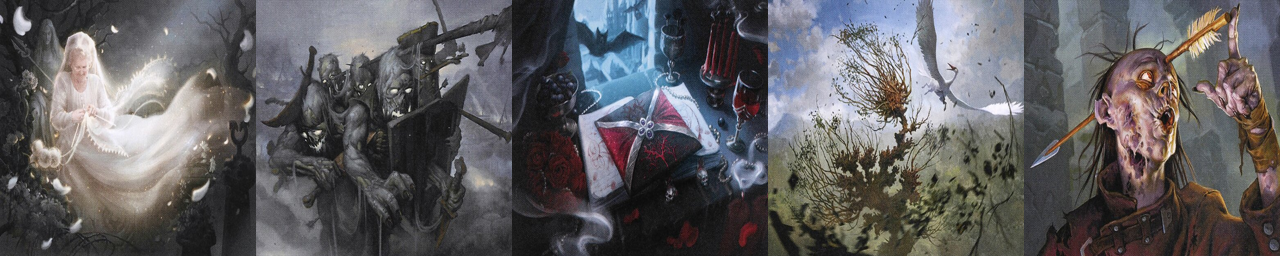

In [9]:
import glob

# change path to display images from your local dir
img_paths = "./sample_data/subset/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [10]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [13]:
import glob
import os
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./sample_data/subset/"
#imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]
imgs_and_paths = [
    (path, Image.open(path), os.path.splitext(path)[0] + ".txt")
    for path in glob.glob(f"{local_dir}*.jpg")
]

In [14]:
imgs_and_paths

[('./sample_data/subset/265a6721-6684-4d9e-9ec1-10b3a41bfbc5.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=626x457>,
  './sample_data/subset/265a6721-6684-4d9e-9ec1-10b3a41bfbc5.txt'),
 ('./sample_data/subset/23f551ea-1409-4540-b33e-570e4383c849.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=626x457>,
  './sample_data/subset/23f551ea-1409-4540-b33e-570e4383c849.txt'),
 ('./sample_data/subset/70e56a7e-5b69-430a-ae1f-1840d743c610.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=626x457>,
  './sample_data/subset/70e56a7e-5b69-430a-ae1f-1840d743c610.txt'),
 ('./sample_data/subset/a477afb0-0e42-4a1f-80d4-21e7f6e80160.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=626x457>,
  './sample_data/subset/a477afb0-0e42-4a1f-80d4-21e7f6e80160.txt'),
 ('./sample_data/subset/cad932d0-b5ce-4558-9110-2bcf7b89aadf.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=626x457>,
  './sample_data/subset/cad932d0-b5ce-4558-9110-2bcf7b89aa

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [16]:
import json

caption_prefix = "in the style of TOK, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      with open(img[2], 'r', encoding='utf-8') as f:
        flav_text = f.read()
      print(flav_text)
      caption = caption_prefix + flav_text +caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

You look cold, dearie.
In case any of you new recruits were wondering, this is why we dont use mass graves anymore.
Kerren of the Mausoleum Guards
RSVP at your own risk.
The forests of this world are unafraid to assert themselves.
Wrenn
Works every time.
Halana, Kessig ranger
By the sixth day of darkness, the lake was more blood than water.
She is cursed with visions of monsters and suffering . . . and all her visions come true.
Before the officiant even had a chance to ask if anyone objected to the VoldarenMarkov union, Arlinn made her opinion known.
Some wicked souls linger only to consume the warmth of life.
The roots preserved the armor for a hundred years, safeguarding it for a traveler in need.
We are not here to mourn their loss. We are here to celebrate their lives.
Vesna, Dawnhart witch
Young vampires gorge themselves at every meal, but their elders have learned to savor the smallest bite.
Some geists imitate the lives they left behind. Others follow the dreams they never real

Free some memory:

In [17]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [18]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [19]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [20]:
!pip install datasets -q

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [24]:
import os
import shutil
import glob

# Исходная папка
src_dir = "sample_data/subset"

# Целевая папка (можно назвать как угодно)
dst_dir = "flav_text"  # или "new_folder", "captions", и т.д.

# Создаём целевую папку, если её нет
os.makedirs(dst_dir, exist_ok=True)

# Находим все .txt файлы в исходной папке
for txt_path in glob.glob(os.path.join(src_dir, "*.txt")):
    filename = os.path.basename(txt_path)          # например: "abc123.txt"
    new_path = os.path.join(dst_dir, filename)     # путь в новой папке
    shutil.move(txt_path, new_path)                # переносим (не копируем!)
    print(f"Перенесено: {filename}")

Перенесено: 48d5b4f9-14c5-4a74-ab5b-70379baf8ed6.txt
Перенесено: 715b46b4-d669-4162-9acb-10d5fa7cbe3e.txt
Перенесено: 8fd26894-b144-4e71-9c4e-9a6d9e665100.txt
Перенесено: 2a91023f-e776-4a04-9f54-4303a3c03fac.txt
Перенесено: a92af45e-3531-4f58-b3bd-6e12c501b63c.txt
Перенесено: ec7b945c-a470-4365-a731-e808122c4497.txt
Перенесено: 17c9da6d-2b03-4748-82de-b9709a3e4a02.txt
Перенесено: 52856002-ecfe-4263-8303-a4fd620b5242.txt
Перенесено: 934978f2-8ca2-47a8-95dd-29cb7d98edae.txt
Перенесено: b4f48d0d-0ecb-458e-b2ec-7d013292fc2b.txt
Перенесено: efce6fe5-0f6d-440e-818e-24c92e7166ce.txt
Перенесено: 33f2d43b-a1cd-4112-8b44-977cc6d3049a.txt
Перенесено: a9b1627e-9d05-4153-984d-8ce60bf00d38.txt
Перенесено: 312393bc-8796-41c5-88be-3f1961a94e33.txt
Перенесено: 88ff03b6-ef96-4e02-a704-efa82490d7ff.txt
Перенесено: e81b9c97-f460-4b8f-a9aa-3e10b80acc94.txt
Перенесено: b3eeec3e-26ff-403c-98a4-bb67ecf67af8.txt
Перенесено: d073c766-d10c-4c2b-b483-31ae12c1c85a.txt
Перенесено: 37655844-7bf5-416d-8447-1dc0d17870

In [32]:
!ls -la sample_data/subset/
!rm -r sample_data/subset/.ipynb_checkpoints

total 12464
drwxr-xr-x 3 root root  20480 Oct 23 14:24 .
drwxr-xr-x 1 root root   4096 Oct 23 14:25 ..
-rw-r--r-- 1 root root  77258 Oct 23 13:14 04145e35-70b4-4636-abd8-b282c6a44af5.jpg
-rw-r--r-- 1 root root  79549 Oct 23 13:13 04e6999f-7621-4d70-a9c5-88025f43ace6.jpg
-rw-r--r-- 1 root root  95682 Oct 23 13:13 04fa325b-35fe-48bc-bec4-1338d8c96c1e.jpg
-rw-r--r-- 1 root root  96279 Oct 23 13:14 05057a6e-7167-4080-b670-4fffa46c22e6.jpg
-rw-r--r-- 1 root root  85281 Oct 23 13:13 0b54a0f0-9e0e-4c1f-882d-ba54205f7e6d.jpg
-rw-r--r-- 1 root root  64950 Oct 23 13:13 0b7679c4-d59e-4e4d-ab19-3f98bfb3729a.jpg
-rw-r--r-- 1 root root  88810 Oct 23 13:13 0d7b415b-b053-459a-a17d-4f48211f76f7.jpg
-rw-r--r-- 1 root root  89062 Oct 23 13:14 1197d2c0-1fc8-486f-b514-714aaf9f0068.jpg
-rw-r--r-- 1 root root  90159 Oct 23 13:14 17c9da6d-2b03-4748-82de-b9709a3e4a02.jpg
-rw-r--r-- 1 root root  83408 Oct 23 13:14 18ce4019-015e-46c2-9d7a-fc332f2d9f90.jpg
-rw-r--r-- 1 root root  88834 Oct 23 13:13 1ad840a4-d7d6-

In [33]:
!ls -la sample_data/subset/

total 12460
drwxr-xr-x 2 root root  20480 Oct 23 14:29 .
drwxr-xr-x 1 root root   4096 Oct 23 14:25 ..
-rw-r--r-- 1 root root  77258 Oct 23 13:14 04145e35-70b4-4636-abd8-b282c6a44af5.jpg
-rw-r--r-- 1 root root  79549 Oct 23 13:13 04e6999f-7621-4d70-a9c5-88025f43ace6.jpg
-rw-r--r-- 1 root root  95682 Oct 23 13:13 04fa325b-35fe-48bc-bec4-1338d8c96c1e.jpg
-rw-r--r-- 1 root root  96279 Oct 23 13:14 05057a6e-7167-4080-b670-4fffa46c22e6.jpg
-rw-r--r-- 1 root root  85281 Oct 23 13:13 0b54a0f0-9e0e-4c1f-882d-ba54205f7e6d.jpg
-rw-r--r-- 1 root root  64950 Oct 23 13:13 0b7679c4-d59e-4e4d-ab19-3f98bfb3729a.jpg
-rw-r--r-- 1 root root  88810 Oct 23 13:13 0d7b415b-b053-459a-a17d-4f48211f76f7.jpg
-rw-r--r-- 1 root root  89062 Oct 23 13:14 1197d2c0-1fc8-486f-b514-714aaf9f0068.jpg
-rw-r--r-- 1 root root  90159 Oct 23 13:14 17c9da6d-2b03-4748-82de-b9709a3e4a02.jpg
-rw-r--r-- 1 root root  83408 Oct 23 13:14 18ce4019-015e-46c2-9d7a-fc332f2d9f90.jpg
-rw-r--r-- 1 root root  88834 Oct 23 13:13 1ad840a4-d7d6-

In [34]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="sample_data/subset" \
  --output_dir="temka_LoRA" \
  --dataset_config_name="sample_data/meta/metadata.jsonl" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="in the style of TOK," \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

2025-10-23 14:30:00.810680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761229800.842687   24865 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761229800.852675   24865 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761229800.880849   24865 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761229800.880881   24865 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761229800.880889   24865 computation_placer.cc:177] computation placer alr

### Save your model to the hub and check it out 🔥

In [35]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "temka_LoRA" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [36]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="in the style of TOK,",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


TypeError: save_model_card() missing 1 required positional argument: 'use_dora'

In [ ]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/LinoyTsaban/corgy_dog_LoRA

Let's generate some images with it!

## Inference 🐕

In [37]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights('temka_LoRA/pytorch_lora_weights.safetensors')
_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/25 [00:00<?, ?it/s]

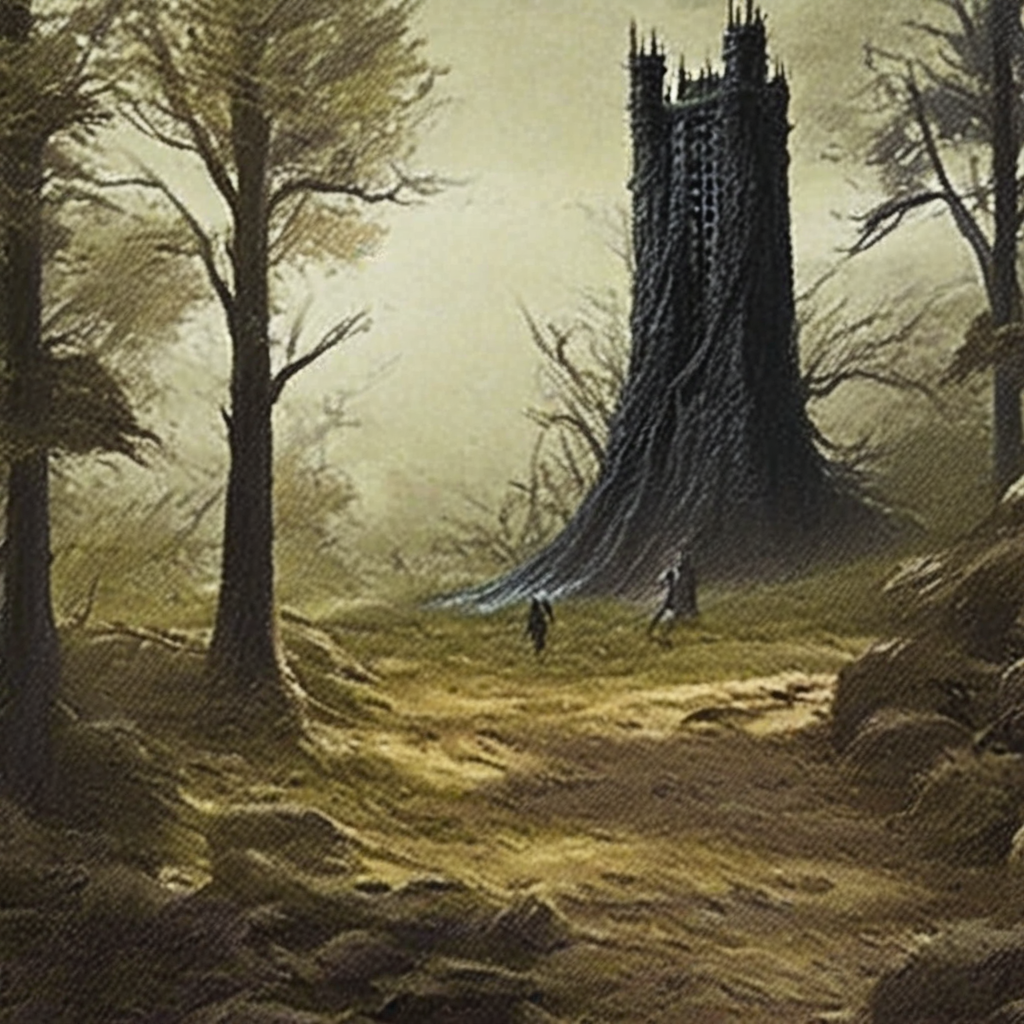

In [63]:
prompt = "in style of TOK, dark tower in woods" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image
